#Not Nessisary To Run Script

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#Load Packages

In [0]:
import string
import glob
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
!gdown https://drive.google.com/uc?id=1LmcVUbFs4SWLc1IetiEQ3ygSAyKZElGS
!tar -xf flickr30k_images.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1LmcVUbFs4SWLc1IetiEQ3ygSAyKZElGS
To: /content/flickr30k_images.tar.gz
4.38GB [00:31, 137MB/s]


In [0]:
!gdown https://drive.google.com/uc?id=1d77Et3Vq03cS1Q4BFmitFJjtFjcP1RiD

Downloading...
From: https://drive.google.com/uc?id=1d77Et3Vq03cS1Q4BFmitFJjtFjcP1RiD
To: /content/Flickr30k.tokens.txt
25.0MB [00:00, 68.4MB/s]


#Load and clean Flickr30k_tokens.txt

In [0]:
# load a document into memory
def load_document(filename, encoding):
	file = open(filename, 'r', encoding=encoding)
	text = file.read()
	file.close()
	return text
doc = load_document('Flickr30k.tokens.txt','utf-16')
print(doc[:500])

1000092795.jpg| 0| Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg| 1| Two young 
1000092795.jpg| 2| Two men in green shirts are standing in a yard .
1000092795.jpg| 3| A man in a blue shirt standing in a garden .
1000092795.jpg| 4| Two friends enjoy time spent together .
10002456.jpg| 0| Several men in hard hats are operating a giant pulley system .
10002456.jpg| 1| Workers look down from up above on a piece of equipment .
10002456.jpg| 2| Two 


In [0]:
def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 31783 


In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)
# clean descriptions
clean_descriptions(descriptions)

#Create full Vocabulary from descriptions

In [0]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 18691


#Size of train test validate sets

In [0]:
train_set_length = 6000
test_set_length =1000
validation_set_length = 500

In [0]:
print(train_set_length-1)
print(train_set_length, (train_set_length)+(test_set_length-1))
print((train_set_length)+(test_set_length), test_set_length + train_set_length + validation_set_length-1)

5999
6000 6999
7000 7499


#Create Train Files

In [0]:
train_img = list(descriptions.keys())[:train_set_length]
data = '\n'.join(train_img)
file = open('flickr30k_images/train.txt', 'w')
file.write(data)
file.close()


In [0]:
#Load paths to all images
images = 'flickr30k_images/flickr30k_images/'
img = glob.glob(images + '*.jpg')
with open('flickr30k_images/img.txt', 'w') as f:
    for item in img:
        f.write("%s\n" % item)
# Below file conatains the names of images to be used in train data
train_images_file = 'flickr30k_images/train.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
# Create a list of all the training images with their full path names
train_img = []
for i in img: # img is list of full path names of all images
	if i[len(images):-4] in train_images: # Check if the image belongs to training set
		train_img.append(i) # Add it to the list of train images
print(train_img)

with open('flickr30k_images/train_img.txt', 'w') as f:
    for item in train_img:
        f.write("%s\n" % item)

['flickr30k_images/flickr30k_images/1509786421.jpg', 'flickr30k_images/flickr30k_images/2441818133.jpg', 'flickr30k_images/flickr30k_images/110820212.jpg', 'flickr30k_images/flickr30k_images/1096305461.jpg', 'flickr30k_images/flickr30k_images/2218843713.jpg', 'flickr30k_images/flickr30k_images/1429814475.jpg', 'flickr30k_images/flickr30k_images/1144865997.jpg', 'flickr30k_images/flickr30k_images/2297744130.jpg', 'flickr30k_images/flickr30k_images/2374652725.jpg', 'flickr30k_images/flickr30k_images/2151230100.jpg', 'flickr30k_images/flickr30k_images/1257692349.jpg', 'flickr30k_images/flickr30k_images/2185255150.jpg', 'flickr30k_images/flickr30k_images/2120309245.jpg', 'flickr30k_images/flickr30k_images/1463072715.jpg', 'flickr30k_images/flickr30k_images/1562478713.jpg', 'flickr30k_images/flickr30k_images/2003663004.jpg', 'flickr30k_images/flickr30k_images/2084103826.jpg', 'flickr30k_images/flickr30k_images/2090997177.jpg', 'flickr30k_images/flickr30k_images/2312746782.jpg', 'flickr30k_i

#Create test files

In [0]:

test_img = list(descriptions.keys())[train_set_length : ((train_set_length)+(test_set_length))]
data = '\n'.join(test_img)
file = open('flickr30k_images/test.txt', 'w')
file.write(data)
file.close()

In [0]:
#Load paths to all images
images = 'flickr30k_images/flickr30k_images/'
img = glob.glob(images + '*.jpg')
with open('flickr30k_images/img.txt', 'w') as f:
    for item in img:
        f.write("%s\n" % item)
# Below file conatains the names of images to be used in test data
test_images_file = 'flickr30k_images/test.txt'
# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
# Create a list of all the testing images with their full path names
test_img = []
for i in img: # img is list of full path names of all images
	if i[len(images):-4] in test_images: # Check if the image belongs to testing set
		test_img.append(i) # Add it to the list of test images
print(test_img)

with open('flickr30k_images/test_img.txt', 'w') as f:
    for item in test_img:
        f.write("%s\n" % item)

['flickr30k_images/flickr30k_images/2560981288.jpg', 'flickr30k_images/flickr30k_images/2512682478.jpg', 'flickr30k_images/flickr30k_images/2458033289.jpg', 'flickr30k_images/flickr30k_images/2536965203.jpg', 'flickr30k_images/flickr30k_images/2455800418.jpg', 'flickr30k_images/flickr30k_images/2451253577.jpg', 'flickr30k_images/flickr30k_images/2529205842.jpg', 'flickr30k_images/flickr30k_images/2504991916.jpg', 'flickr30k_images/flickr30k_images/254308532.jpg', 'flickr30k_images/flickr30k_images/244910177.jpg', 'flickr30k_images/flickr30k_images/2513260012.jpg', 'flickr30k_images/flickr30k_images/2537806838.jpg', 'flickr30k_images/flickr30k_images/2462153092.jpg', 'flickr30k_images/flickr30k_images/2496236371.jpg', 'flickr30k_images/flickr30k_images/2534904279.jpg', 'flickr30k_images/flickr30k_images/2551007516.jpg', 'flickr30k_images/flickr30k_images/2501942587.jpg', 'flickr30k_images/flickr30k_images/2552723989.jpg', 'flickr30k_images/flickr30k_images/2536850983.jpg', 'flickr30k_im

#Create validation files

In [0]:
validate_img = list(descriptions.keys())[len(list(descriptions.keys()))- validation_set_length :len(list(descriptions.keys()))]
data = '\n'.join(validate_img)
file = open('flickr30k_images/validate.txt', 'w')
file.write(data)
file.close()

In [0]:
#Load paths to all images
images = 'flickr30k_images/flickr30k_images/'
img = glob.glob(images + '*.jpg')
with open('flickr30k_images/img.txt', 'w') as f:
    for item in img:
        f.write("%s\n" % item)
# Below file conatains the names of images to be used in Validation data
validate_images_file = 'flickr30k_images/validate.txt'
# Read the validation image names in a set
validate_images = set(open(validate_images_file, 'r').read().strip().split('\n'))
# Create a list of all the validation images with their full path names
validate_img = []
for i in img: # img is list of full path names of all images
	if i[len(images):-4] in validate_images: # Check if the image belongs to validation set
		validate_img.append(i) # Add it to the list of validation images
print(validate_img)

with open('flickr30k_images/validate_img.txt', 'w') as f:
    for item in validate_img:
        f.write("%s\n" % item)

['flickr30k_images/flickr30k_images/958317706.jpg', 'flickr30k_images/flickr30k_images/944424269.jpg', 'flickr30k_images/flickr30k_images/843218288.jpg', 'flickr30k_images/flickr30k_images/97105139.jpg', 'flickr30k_images/flickr30k_images/91251257.jpg', 'flickr30k_images/flickr30k_images/92732320.jpg', 'flickr30k_images/flickr30k_images/83755390.jpg', 'flickr30k_images/flickr30k_images/93922153.jpg', 'flickr30k_images/flickr30k_images/909191414.jpg', 'flickr30k_images/flickr30k_images/82680989.jpg', 'flickr30k_images/flickr30k_images/86127083.jpg', 'flickr30k_images/flickr30k_images/86112730.jpg', 'flickr30k_images/flickr30k_images/86800579.jpg', 'flickr30k_images/flickr30k_images/868984478.jpg', 'flickr30k_images/flickr30k_images/846085364.jpg', 'flickr30k_images/flickr30k_images/94987177.jpg', 'flickr30k_images/flickr30k_images/95758790.jpg', 'flickr30k_images/flickr30k_images/871290646.jpg', 'flickr30k_images/flickr30k_images/991459823.jpg', 'flickr30k_images/flickr30k_images/855430

#Save Descriptions to File

In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

#Save descriptions to descriptions.txt
save_descriptions(descriptions, 'flickr30k_images/descriptions.txt')

#load training image tages 

In [0]:
# load descriptions document
doc = load_document('Flickr30k.tokens.txt','utf-16')
print(doc[:300])
train = load_document('flickr30k_images/train.txt','utf-8')


1000092795.jpg| 0| Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg| 1| Two young 
1000092795.jpg| 2| Two men in green shirts are standing in a yard .
1000092795.jpg| 3| A man in a blue shirt standing in a garden .
1000092795.jpg| 4| Two friends enjo


#Create description dictionary for train images

In [0]:
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_document(filename,'utf-8')
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('flickr30k_images/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6002


#preprocess images

In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

#****automatic feature engineering.

In [0]:
# load the Xception model
model = Xception(weights='imagenet')

In [0]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 3s 0us/step


In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

#Full train encoding with training set size 27k

In [0]:
!gdown https://drive.google.com/uc?id=1-x871crbr9Vv2PZhMP5RRI4krIQMnJDi

Downloading...
From: https://drive.google.com/uc?id=1-x871crbr9Vv2PZhMP5RRI4krIQMnJDi
To: /content/encoded_train_images.pkl
49.6MB [00:01, 44.5MB/s]


#Encode all Training Images (Potentially Time Consuming)

In [0]:
start = time()
encoding_train = {}
cnt = 0
for img in train_img:
    img = img[:]
    print(cnt, img[len(images):])
    encoding_train[img[len(images):]] = encode(img)
    cnt+=1
print("Time taken in seconds =", time()-start)

In [0]:
import pickle
# Save the bottleneck train features to disk
with open("gdrive/My Drive/Image Captioning /encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [0]:
with open("flickr30k_images/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [0]:
print(len(encoding_train))

6000


#Encode all test images

In [0]:
start = time()
encoding_test = {}
cnt = 0
for img in test_img:
    img = img[:]
    print(cnt, img[len(images):], time()-start)
    encoding_test[img[len(images):]] = encode(img)
    cnt+=1
print("Time taken in seconds =", time()-start)

0 2560981288.jpg 0.0036122798919677734
1 2512682478.jpg 5.251996755599976
2 2458033289.jpg 5.278782606124878
3 2536965203.jpg 5.299494981765747
4 2455800418.jpg 5.319752931594849
5 2451253577.jpg 5.338511228561401
6 2529205842.jpg 5.3593621253967285
7 2504991916.jpg 5.378125429153442
8 254308532.jpg 5.398392915725708
9 244910177.jpg 5.417328119277954
10 2513260012.jpg 5.438581943511963
11 2537806838.jpg 5.461313009262085
12 2462153092.jpg 5.481836318969727
13 2496236371.jpg 5.501093149185181
14 2534904279.jpg 5.519705533981323
15 2551007516.jpg 5.537424564361572
16 2501942587.jpg 5.557703256607056
17 2552723989.jpg 5.578914642333984
18 2536850983.jpg 5.599247932434082
19 2449289139.jpg 5.618818521499634
20 2549203985.jpg 5.640063524246216
21 2480158575.jpg 5.657902717590332
22 2542282004.jpg 5.681679725646973
23 2494822758.jpg 5.701320648193359
24 2533076864.jpg 5.721159934997559
25 2460804866.jpg 5.74141263961792
26 2477623312.jpg 5.760536193847656
27 2484380735.jpg 5.779902219772339


In [0]:
import pickle
# Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [0]:
print(len(encoding_test))

1000


#Load encoded training images

In [0]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))


Photos: train=6000


# Create a list of all the training captions

In [0]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30010

# Consider only words which occur at least 10 times in the corpus of training captions

In [0]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 9099 -> 1955


#Save vocabulary to text for future use

In [0]:
Vocabulary_Name = 'original_Setup_vocabulary'
data = '\n'.join(vocab)
file = open('gdrive/My Drive/Image Captioning /' + Vocabulary_Name + '.txt', 'w')
file.write(data)
file.close()

FileNotFoundError: ignored

#One hot encoding of words

In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1


In [0]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1956

In [0]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 41


#Data Generator

In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key + '.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

#load glove files

In [0]:
!gdown https://drive.google.com/uc?id=1m4usqxA8U2ejCweFl0dWqAGKElM9HIng
!tar -xf glove.6B.200d.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1m4usqxA8U2ejCweFl0dWqAGKElM9HIng
To: /content/glove.6B.200d.tar.gz
241MB [00:01, 133MB/s]


In [0]:
#Load Glove vectors
glove_dir = '/glove'
embeddings_index = {} # empty dictionary
f = open('glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(1956, 200)

#Standard Model Results
training = 6000 bleu = .51\
training = 500 bleu = .44

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

#Optimal Model ***
training = 500 bleu = .45 \
training = 500 batch size = 100,200 bleu = 0.5108587361155279 \
training = 6000 batch size = 100,200 dropout = .5 , .1 bleu = 0.5536554397290601

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.1)(se1) #changed dropout to .1
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

#Various models tried

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='tanh')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.1)(se1) #changed dropout to .1
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='tanh')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dense(512, activation='relu')(inputs1)
fe2 = Dropout(0.5)(fe1)
fe3 = Dense(256, activation='relu')(fe2)
fe4 = Dropout(.1)(fe3)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe4, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [0]:
inputs1 = Input(shape=(2048,))
bn1 = BatchNormalization()(inputs1)
fe2 = Dense(256, activation='relu')(bn1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
bn2 = BatchNormalization()(se1)
se3 = LSTM(256)(bn2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

#Summary of chosen model

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 41)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 41, 200)      391200      input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 

In [0]:
model.layers[2]

#Set weights of embeding matrix to prelearned weights from GloVe  file freeze weights so that they dont change during back propagation

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

#Compile Model

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

#Set Hyper Parameters for Training

In [0]:
epochs = 10
number_pics_per_bath = 100
steps = len(train_descriptions)//number_pics_per_bath

#Training Model for 20 epochs (Skip training section to load optimal weights)

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('flickr30k_images/model_' + str(i) + '.h5')

Epoch 1/1
60/60 [==============================] - 42s 707ms/step - loss: 5.5265
Epoch 1/1
60/60 [==============================] - 24s 396ms/step - loss: 4.6375
Epoch 1/1
60/60 [==============================] - 24s 394ms/step - loss: 4.1601
Epoch 1/1
60/60 [==============================] - 24s 392ms/step - loss: 3.8926
Epoch 1/1
60/60 [==============================] - 24s 395ms/step - loss: 3.7170
Epoch 1/1
60/60 [==============================] - 24s 397ms/step - loss: 3.5894
Epoch 1/1
60/60 [==============================] - 24s 392ms/step - loss: 3.4863
Epoch 1/1
60/60 [==============================] - 24s 395ms/step - loss: 3.4041
Epoch 1/1
60/60 [==============================] - 24s 393ms/step - loss: 3.3346
Epoch 1/1
60/60 [==============================] - 24s 393ms/step - loss: 3.2737


In [0]:

model.save_weights('gdrive/My Drive/Image Captioning /model_10__tr-500_te-100_val-50_tanh')

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('flickr30k_images/model_' + str(i) + '.h5')

Epoch 1/1
60/60 [==============================] - 24s 396ms/step - loss: 3.2168
Epoch 1/1
60/60 [==============================] - 24s 398ms/step - loss: 3.1644
Epoch 1/1
60/60 [==============================] - 24s 393ms/step - loss: 3.1183
Epoch 1/1
60/60 [==============================] - 24s 394ms/step - loss: 3.0739
Epoch 1/1
60/60 [==============================] - 24s 398ms/step - loss: 3.0358
Epoch 1/1
60/60 [==============================] - 24s 399ms/step - loss: 3.0000
Epoch 1/1
60/60 [==============================] - 24s 392ms/step - loss: 2.9642
Epoch 1/1
60/60 [==============================] - 24s 394ms/step - loss: 2.9289
Epoch 1/1
60/60 [==============================] - 24s 397ms/step - loss: 2.9007
Epoch 1/1
60/60 [==============================] - 24s 393ms/step - loss: 2.8699


In [0]:
model.save_weights('gdrive/My Drive/Image Captioning /model_20__tr-6000_te-1000_val-500_tanh')

#Optimize model and train for 10 more epochs

In [0]:
model.load_weights('gdrive/My Drive/Image Captioning /model_20__tr-27000_te-1000_val-50_dr-5-1.h5')

In [0]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 150
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [0]:

model.save_weights('gdrive/My Drive/Image Captioning /model_30__tr-27000_te-1000_val-50_dr-5-1.h5')

#Load weights to Optimal Model

In [127]:
!gdown https://drive.google.com/uc?id=10BTkOGGaxWvuk0g7hWJjh0YQ-lCZ789_

Downloading...
From: https://drive.google.com/uc?id=10BTkOGGaxWvuk0g7hWJjh0YQ-lCZ789_
To: /content/model_20__tr-27000_te-1000_val-50_dr-5-1.h5
12.7MB [00:00, 75.5MB/s]


In [0]:
model.load_weights('model_20__tr-27000_te-1000_val-50_dr-5-1.h5')

#Code to Caption test images

In [0]:
images = 'flickr30k_images/flickr30k_images/'

In [0]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

#Results of test set

2451253577.jpg
[[0.32706705 0.23219906 0.402852   ... 0.41219383 0.07193284 1.0721546 ]]


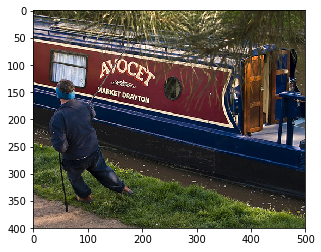

Greedy: man in blue shirt and jeans is standing on the edge of the road
Real Captions: man pulls rope that is attached to floating boat marked avocet market drayton
BLEU Score:  0.565462491617351
2529205842.jpg
[[0.08529852 0.66265815 0.0963049  ... 0.14566621 0.19101739 1.0557008 ]]


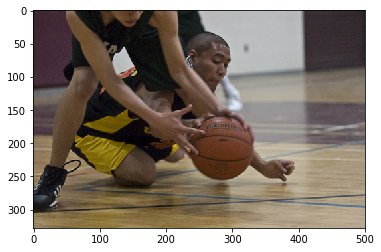

Greedy: basketball player in white uniform is shooting the ball
Real Captions: two basketball players
BLEU Score:  0.7277847634361553
2504991916.jpg
[[0.18467543 0.3068195  0.7152119  ... 0.9372425  0.25587618 0.45985472]]


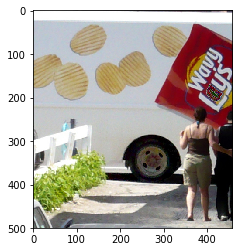

Greedy: man in blue shirt is standing in front of truck
Real Captions: lay potato chip truck at the end of path and two people walking
BLEU Score:  0.42224873307866406
254308532.jpg
[[1.4499307  0.19945545 1.0701809  ... 0.20853753 0.25702953 0.58162624]]


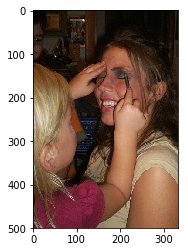

Greedy: two girls are smiling at the camera
Real Captions: child putting eye makeup on another woman
BLEU Score:  0.40818200024645296


In [132]:
from nltk.translate.bleu_score import sentence_bleu
for z in range(5,9):
  pic = list(encoding_test.keys())[z]
  print(pic)
  image = encoding_test[pic].reshape((1,2048))
  print(image)
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  print("Greedy:",greedySearch(image))
  print("Real Captions: " + str(descriptions[pic[:-4]][z%5]))
  print('BLEU Score: ', sentence_bleu(descriptions[pic[:-4]],greedySearch(image)))

#Calculate Mean BLEU Score
original model training size = 6000, bleu = .51

In [133]:
import statistics
from nltk.translate.bleu_score import sentence_bleu

bleu = {}
cnt = 0
for z in range(len(encoding_test.keys())):
  print(cnt)
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,2048))
  bleu[z] =  sentence_bleu(descriptions[pic[:-4]],greedySearch(image))
  cnt+=1

sum = 0
for i in range(1,len(bleu)):
  sum +=bleu[i]
mean_bleu = sum/len(bleu)
print(mean_bleu)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
for i in range(len(bleu)):
  print(i, bleu[i])

0 0.4626288798021948
1 0.8684082790116184
2 0.3735722249561461
3 0.6002632558890727
4 0.48894573624990634
5 0.6024418687659667
6 0.8017400328494911
7 0.6068929389308906
8 0.6632803347974962
9 0.5970773317195169
10 0.6584546271723029
11 0.4522181628745414
12 0.3614031337944815
13 0.529117108169774
14 0.6386394739317064
15 0.539742363408094
16 0.4984623088047321
17 0.6779438273067367
18 0.6187988595395328
19 0.6606642364089096
20 0.4254244290738656
21 0.7660029985271027
22 0.7467230818139178
23 0.49958426809203116
24 0.3822890643449318
25 0.44173284639670485
26 0.5766042374984367
27 0.7016879391277372
28 0.6417487236332399
29 0.904265685293808
30 0.8329321803655267
31 0.6357353579620004
32 0.5037809499768643
33 0.6662002927220049
34 0.6562365628220935
35 0.5613858106076023
36 0.4596486529231998
37 0.48515798548617345
38 0.7112852579720855
39 0.616168157487061
40 0.7359638847455141
41 0.3818269604456097
42 0.2799640662094316
43 0.4244547360752206
44 0.4244518644123725
45 0.674806176326657

In [0]:
max_bleu = 0
for i in range(len(bleu)):
  if bleu[i]>max_bleu:
    print(i,bleu[i])
    max_bleu = bleu[i]
  i+=1

0 0.4626288798021948
1 0.8684082790116184
29 0.904265685293808
152 1.0


#My Own Picture

In [0]:
import numpy as np
from numpy import array
from PIL import Image
import pickle
test_pic= encode('gdrive/My Drive/Test photos AIC/20190508_185733.jpg')
my_test_image = test_pic
with open("flickr30k_images/my_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(my_test_image, encoded_pickle)



[[0.53991425 0.46172696 0.34359828 ... 0.06939692 0.18318579 0.44159928]]


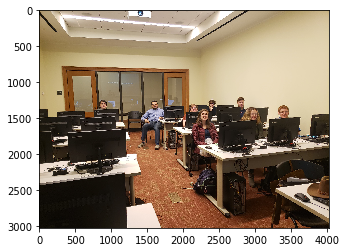

Greedy: man in black shirt is standing in front of computer


In [0]:
with open("flickr30k_images/my_test_images.pkl", "rb") as encoded_pickle:
    my_encoding_test = load(encoded_pickle)

#pic = list(my_encoding_test.keys())[1]
#print(pic)
image = my_encoding_test.reshape((1,2048))
print(image)
x=plt.imread('gdrive/My Drive/Test photos AIC/20190508_185733.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))